In [2]:
import tensorflow as tf
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/chest_xray",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
len(dataset)

92

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 1]


In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy().min())
    print(image_batch[0].numpy().max())

0.0
252.98438


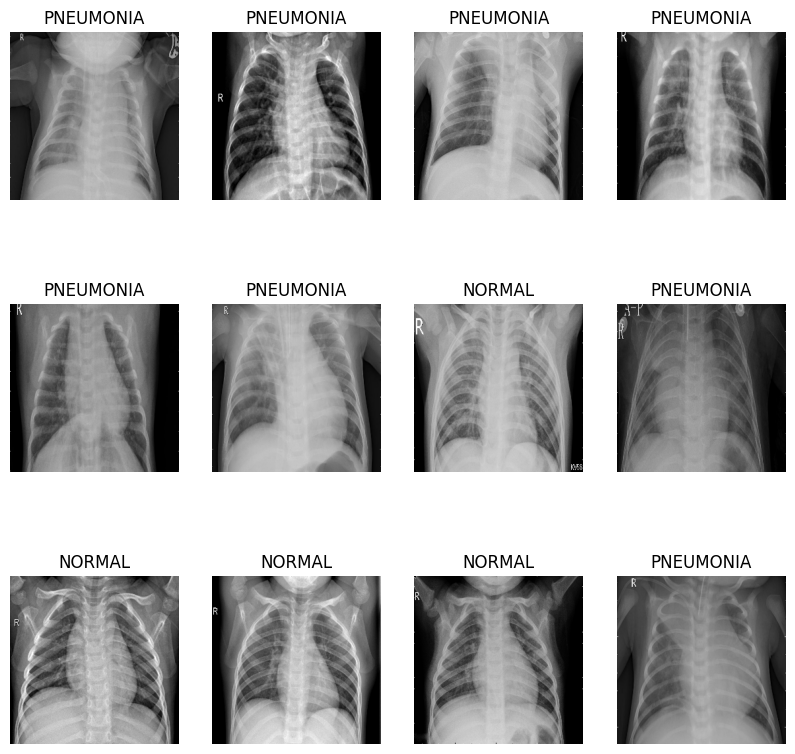

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):

    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
80% ==> training
20% ==> 10% validation, 10% test

In [ ]:
train_size = 0.8
len(dataset)*train_size

73.60000000000001

In [ ]:
train_ds = dataset.take(73)
len(train_ds)

73

In [ ]:
test_ds = dataset.skip(73)
len(test_ds)

19

In [ ]:
val_size = 0.1
len(dataset)*val_size

9.200000000000001

In [ ]:
val_ds = test_ds.take(9)
len(val_ds)

9

In [ ]:
test_ds = test_ds.skip(9)
len(test_ds)

10

In [23]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=500):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [24]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [ ]:
len(val_ds)

9

In [ ]:
len(test_ds)

10

In [25]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [27]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (64, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 62, 62, 64)          0         
 g2D)                                                 

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=75,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/75
73/73 [==============================] - 9s 120ms/step - loss: 0.1513 - accuracy: 0.9444 - val_loss: 0.1724 - val_accuracy: 0.9236
Epoch 2/75
73/73 [==============================] - 8s 113ms/step - loss: 0.1455 - accuracy: 0.9442 - val_loss: 0.2266 - val_accuracy: 0.9097
Epoch 3/75
73/73 [==============================] - 8s 114ms/step - loss: 0.1493 - accuracy: 0.9466 - val_loss: 0.1537 - val_accuracy: 0.9427
Epoch 4/75
73/73 [==============================] - 9s 117ms/step - loss: 0.1544 - accuracy: 0.9418 - val_loss: 0.1535 - val_accuracy: 0.9375
Epoch 5/75
73/73 [==============================] - 8s 114ms/step - loss: 0.1467 - accuracy: 0.9446 - val_loss: 0.1413 - val_accuracy: 0.9444
Epoch 6/75
73/73 [==============================] - 8s 115ms/step - loss: 0.1518 - accuracy: 0.9399 - val_loss: 0.1669 - val_accuracy: 0.9340
Epoch 7/75
73/73 [==============================] - 8s 114ms/step - loss: 0.1589 - accuracy: 0.9444 - val_loss: 0.1720 - val_accuracy: 0.9340
Epoch 

In [32]:
model_version=2
model.save(f"/content/drive/MyDrive/models/{model_version}")

In [13]:
MODEL = tf.keras.models.load_model("/content/drive/MyDrive/models/1")

In [14]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions =model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


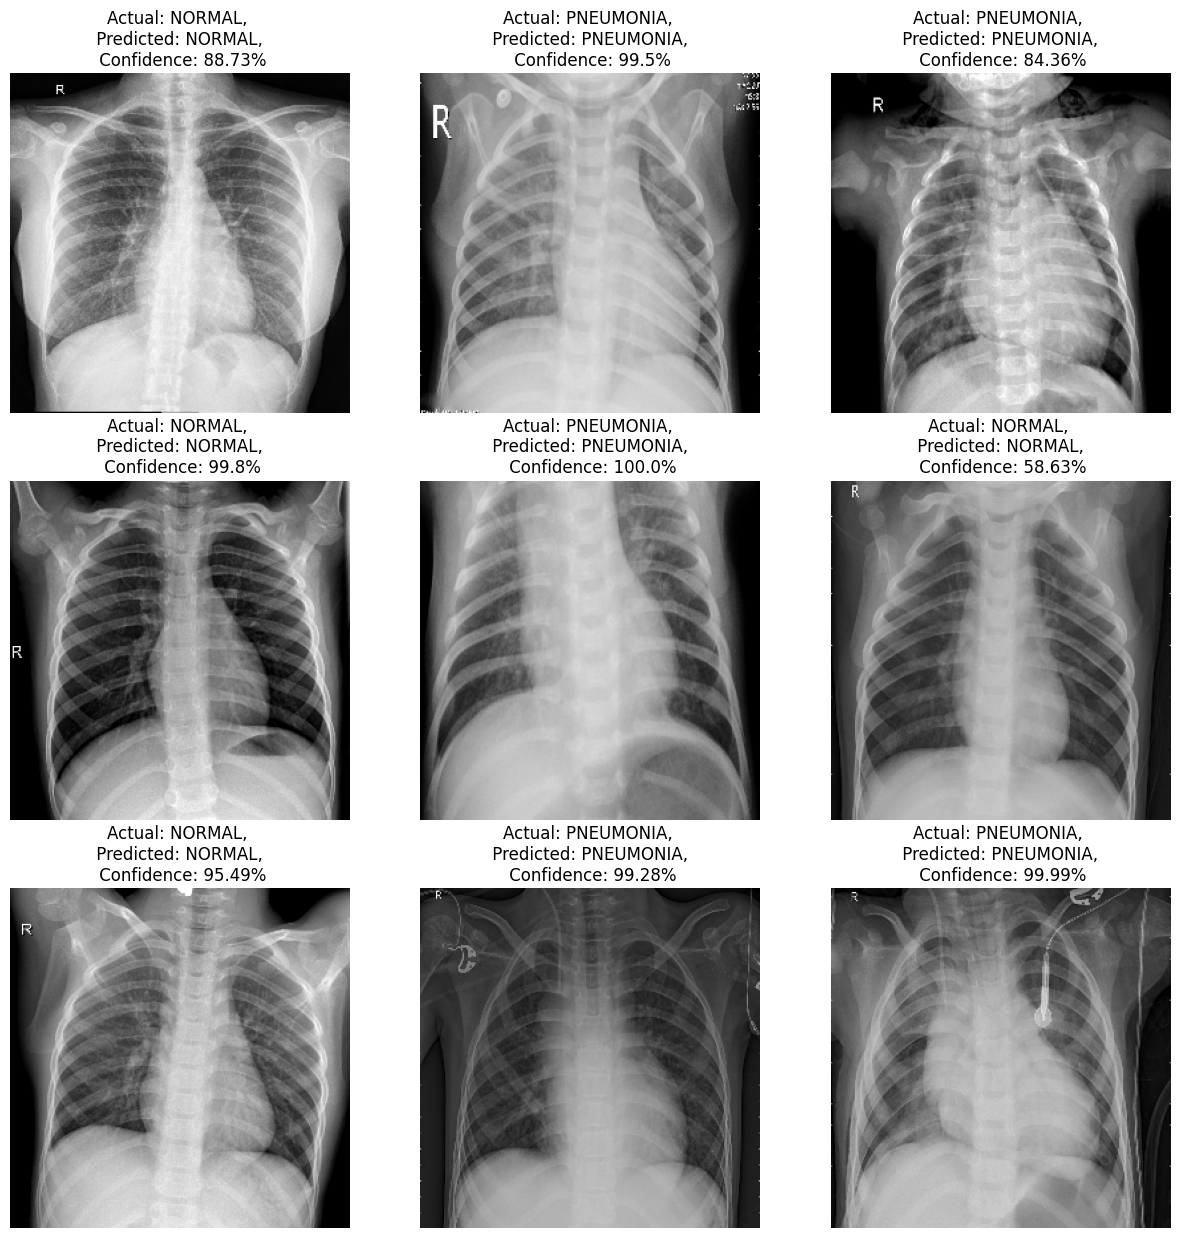

In [15]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(MODEL, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
MODEL.predict()